# Examples of DRGs

This notebook produces the DRG examples in the paper, and serves as a general guide for creating DRGs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import itertools
import plotly.graph_objects as go

from gtda.plotting import plot_point_cloud
from ripser import ripser
from persim import PersistenceImager, plot_diagrams
import gudhi as gd
from ot import fused_gromov_wasserstein2
import ot

import trimesh

from DecoratedReebGraphs import *

## Toy Example

A simple synthetic example to illustrate the features of the DRG.

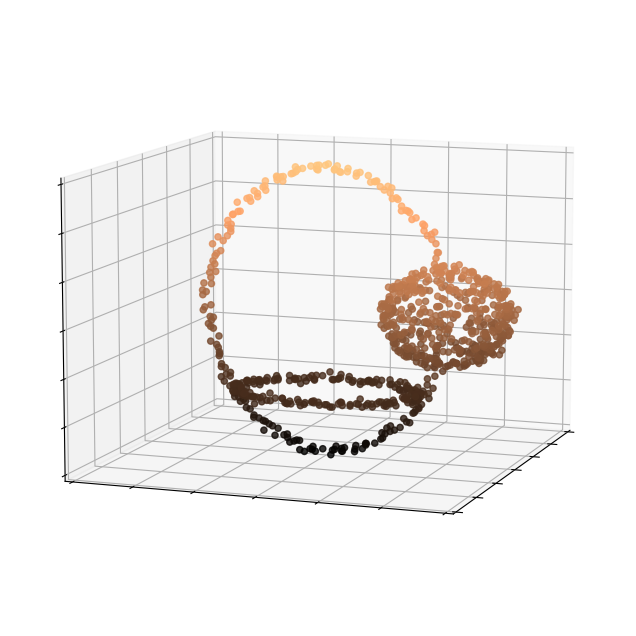

In [2]:
R = 0.75
N = 500

sphere = []

for n in range(N):
    v = R*(np.random.rand(3) - np.random.rand(3))
    sphere.append(v/np.linalg.norm(v))
    
sphere = np.array(sphere)
sphere_function = sphere[:,2]

ts = np.linspace(np.pi/8,2*np.pi-np.pi/8,200)
circle = np.array([np.zeros(len(ts)),2*np.cos(ts),3*np.sin(ts)]).T - np.array([0,2,0])

ts2 = np.linspace(0,2*np.pi,200)
circle2 = np.array([np.cos(ts2),1.5*np.sin(ts2),np.zeros(len(ts2))]).T + np.array([0,-2,-1.75])

data = np.vstack([sphere,circle,circle2]) + np.array([0,2,0])
data += np.random.normal(0,.05,data.shape)
function = data[:,2]

plot_3d_point_cloud(data, function = function)

Fitting the Decorated Reeb Graph (DRG).

This is handled by the `DecoratedReebGraph` class. 

The DRG consists of an approximation of the Reeb graph of the shape (see documentation for various parameter options), plus a persistence diagram attached to each node. 

The filter function is height along the z-axis (`function` was defined above).

In [3]:
#Initialize the DRG
DRG = DecoratedReebGraph(data = data, function = function)
# Create 2-skeleton of the global Vietoris-Rips complex for the whole point cloud
DRG.fit_Vietoris_Rips(min_rad_factor=3)
# Fit the Reeb graph using the VR complex skeleton
DRG.fit_Reeb(n_bins=12)
# Construct localized VR persistence diagrams attached to each node of the DRG
DRG.fit_diagrams()

Plots the Reeb graph, with nodes colored by total persistence.

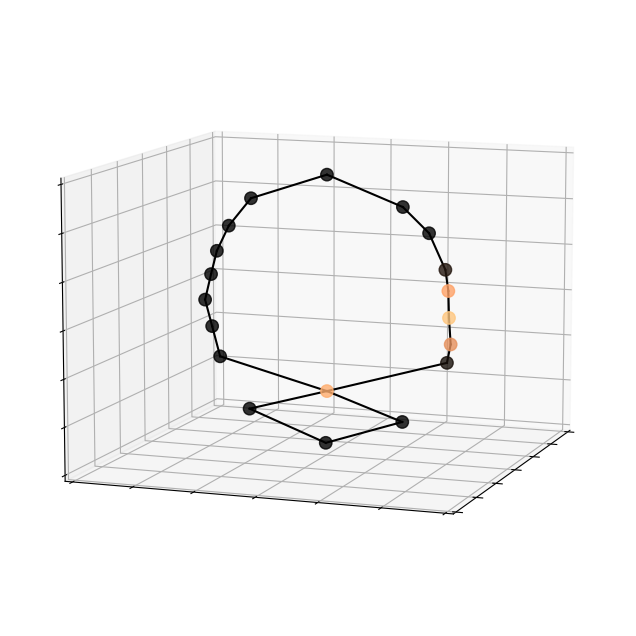

In [4]:
plot_Reeb_3d(DRG.ReebGraph, node_color = 'total')

Plotting persistence diagrams associated to nodes.

In [5]:
G = DRG.ReebGraph

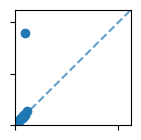

In [6]:
node = (2,0)
dgm = G.nodes[node]['diagram']
max_val = 2.25

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

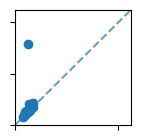

In [7]:
node = (5,0)
dgm = G.nodes[node]['diagram']
max_val = 2.25

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

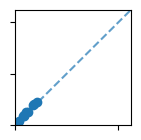

In [8]:
node = (7,0)
dgm = G.nodes[node]['diagram']
max_val = 2.25

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

Plotting subsets of the original point cloud associated to nodes of the persistence diagram.

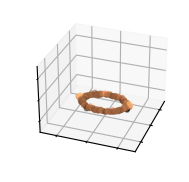

In [9]:
node = (2,0)
data_subset = data[G.nodes[node]['component indices'],:]

fig = plt.figure(figsize = (2,2))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_subset[:,0],data_subset[:,1],data_subset[:,2], c = function[G.nodes[node]['component indices']], cmap = plt.cm.copper,alpha = 0.5,s = 10)
ax.set_xlim3d(-3,3)
ax.set_ylim3d(-3,3)
ax.set_zlim3d(-3,3)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(elev=30., azim=20)

plt.show()

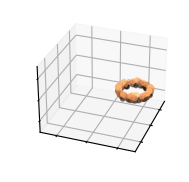

In [10]:
node = (5,0)
data_subset = data[G.nodes[node]['component indices'],:]

fig = plt.figure(figsize = (2,2))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_subset[:,0],data_subset[:,1],data_subset[:,2], c = function[G.nodes[node]['component indices']], cmap = plt.cm.copper,alpha = 0.5,s = 10)
ax.set_xlim3d(-3,3)
ax.set_ylim3d(-3,3)
ax.set_zlim3d(-3,3)
# ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(elev=30., azim=20)

plt.show()

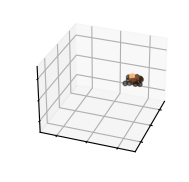

In [11]:
node = (7,0)
data_subset = data[G.nodes[node]['component indices'],:]

fig = plt.figure(figsize = (2,2))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_subset[:,0],data_subset[:,1],data_subset[:,2], c = function[G.nodes[node]['component indices']], cmap = plt.cm.copper,alpha = 0.5,s = 10)
ax.set_xlim3d(-3,3)
ax.set_ylim3d(-3,3)
ax.set_zlim3d(-3,3)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(elev=30., azim=20)

plt.show()

## ModelNet10 Example

Another example, using a point cloud extracted from a ModelNet10 CAD model.

**Note:** You need to unzip the `modelNetPointClouds1024.pickle` file to run this.

In [12]:
import pickle

In [13]:
with open("Data/modelNetPointClouds1024.pickle", "rb") as f:
    full_dataset = pickle.load(f)
    
training_data_point_clouds = full_dataset['train_points']
testing_data_point_clouds = full_dataset['test_points']

training_labels = full_dataset['train_labels']
testing_labels = full_dataset['test_labels']

Class: night_stand


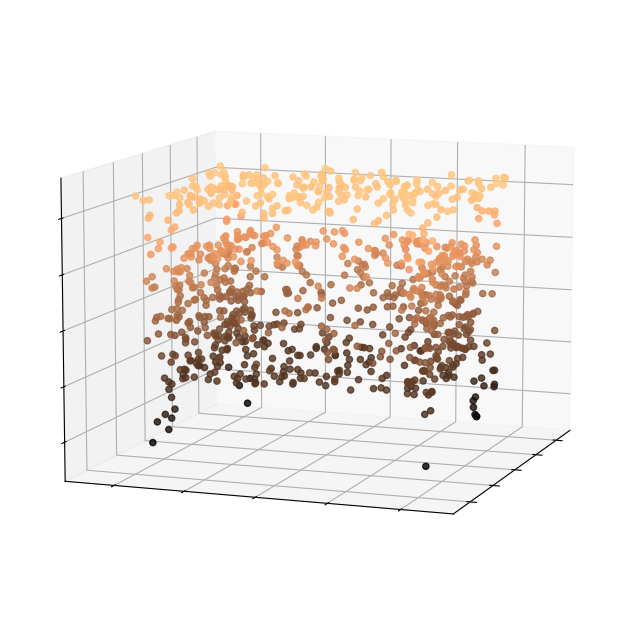

In [14]:
class_id = 8
sample_number = 1
print('Class:',full_dataset['class_map'][class_id])

idx = np.where(full_dataset['train_labels']==class_id)[0][0] + sample_number

data = training_data_point_clouds[idx,:,:]
function = data[:,2]

plot_3d_point_cloud(data, box = (-13,13), function = function)

Fitting the DRG.

/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you

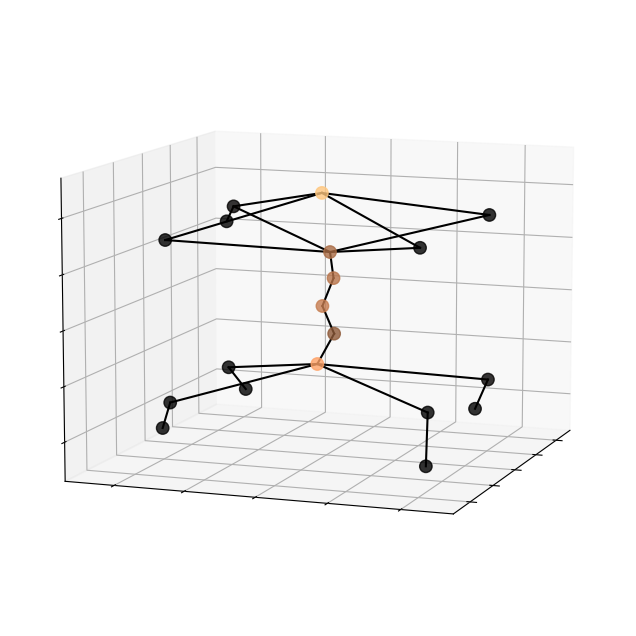

In [15]:
DRG = DecoratedReebGraph(data = data, function = function)
DRG.fit_Vietoris_Rips()
DRG.fit_Reeb()
DRG.fit_diagrams()

plot_Reeb_3d(DRG.ReebGraph, node_color = 'total', box = (-13,13))

Plotting some persistence diagrams.

In [16]:
G = DRG.ReebGraph

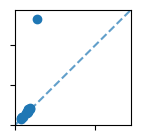

In [17]:
node = (4,0)
dgm = G.nodes[node]['diagram']
max_val = 14.5

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

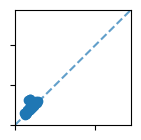

In [18]:
node = (8,0)
dgm = G.nodes[node]['diagram']
max_val = 14.5

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

Plotting subsets of the original point cloud associated to nodes of the persistence diagram.

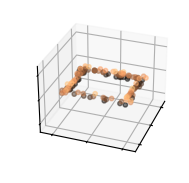

In [19]:
node = (4,0)
data_subset = data[G.nodes[node]['component indices'],:]

fig = plt.figure(figsize = (2,2))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_subset[:,0],data_subset[:,1],data_subset[:,2], c = function[G.nodes[node]['component indices']], cmap = plt.cm.copper,alpha = 0.5,s = 10)
ax.set_xlim3d(-13,13)
ax.set_ylim3d(-13,13)
ax.set_zlim3d(-13,13)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(elev=30., azim=20)

plt.show()

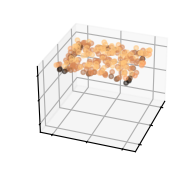

In [20]:
node = (8,0)
data_subset = data[G.nodes[node]['component indices'],:]

fig = plt.figure(figsize = (2,2))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_subset[:,0],data_subset[:,1],data_subset[:,2], c = function[G.nodes[node]['component indices']], cmap = plt.cm.copper,alpha = 0.5,s = 10)
ax.set_xlim3d(-13,13)
ax.set_ylim3d(-13,13)
ax.set_zlim3d(-13,13)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.view_init(elev=30., azim=20)

plt.show()

## SHREC14 Example

Another example using a point cloud from the SHREC14 Dataset.

In [21]:
with open("Data/SHRECPointClouds1024.pickle", "rb") as f:
    full_dataset = pickle.load(f)
    
training_data_point_clouds = full_dataset['train_points']
testing_data_point_clouds = full_dataset['test_points']

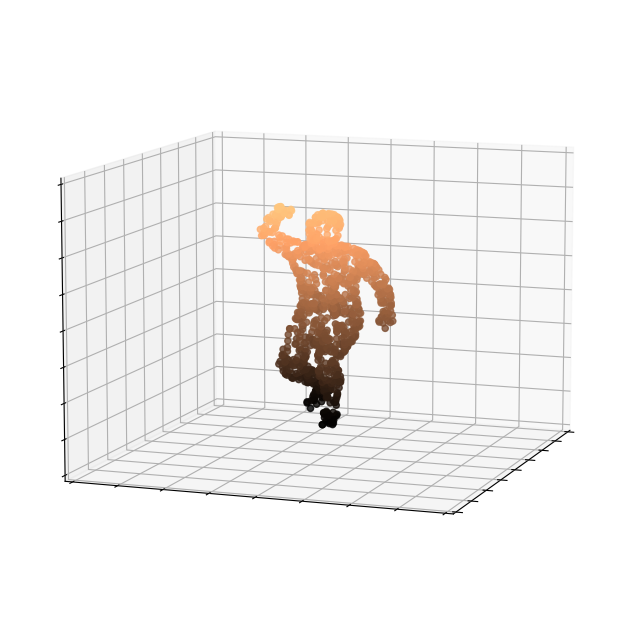

In [32]:
idx = 10

data0 = training_data_point_clouds[idx,:,:]
data0[:,[1,2]] = data0[:,[2,1]]

plot_3d_point_cloud(data0, box = (-1,1))

Here, we will use a different function (not height along $z$-axis) as the filter function. 

We'll use an eccentricity function, as defined below.

In [33]:
from sklearn.neighbors import NearestNeighbors

In [34]:
def p_eccentricity_knn(point_cloud,p,k):
    
    # Compute the k-NN graph
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='kd_tree').fit(point_cloud)
    _, indices = nbrs.kneighbors(point_cloud)

    # Build the adjacency matrix
    adjacency_matrix = np.zeros((len(point_cloud), len(point_cloud)))
    for i, neighbors in enumerate(indices):
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1

    graph = nx.from_numpy_array(adjacency_matrix)
    
    D = np.array(nx.floyd_warshall_numpy(graph))
    
    return np.sum(D**p,axis = 0)**(1/p)

In [35]:
def p_eccentricity_VR(data,p):
    
    DRG = DecoratedReebGraph(data = data, function = p_eccentricity_knn(data,p,10))
    DRG.fit_Vietoris_Rips()
    D = np.array(nx.floyd_warshall_numpy(DRG.VRGraph))
    
    return np.sum(D**p,axis = 0)**(1/p)

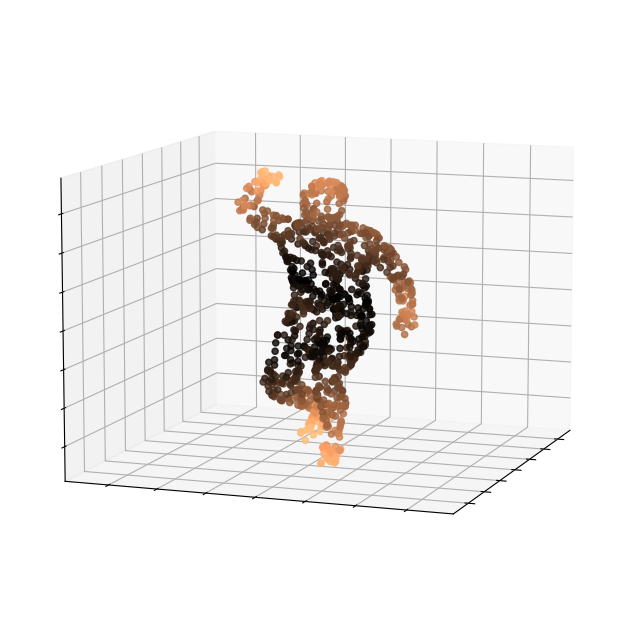

In [36]:
data = data0
function = p_eccentricity_VR(data,100)
plot_3d_point_cloud(data0, box = (-.75,.75), function = function)

/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/Users/needham/opt/anaconda3/envs/drgGNN/lib/python3.9/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


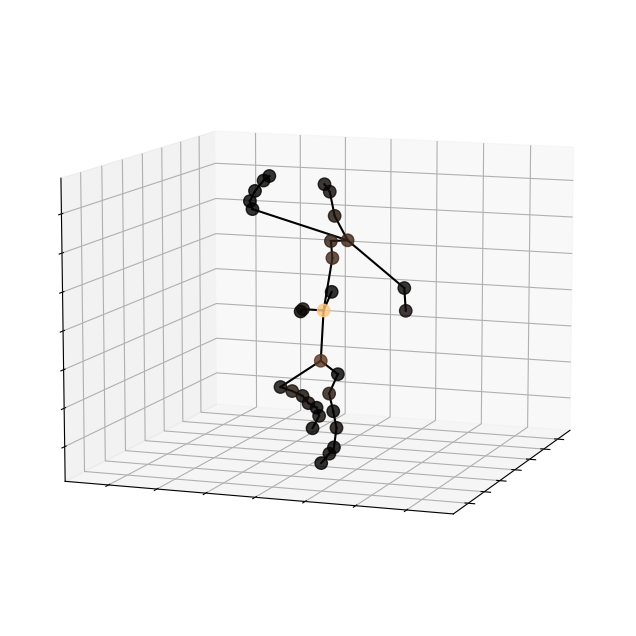

In [37]:
pixel_size = 0.001
birth_range = (0,0.3)
pers_range = (0,0.3)
kernel_params = {'sigma': [[0.00001, 0.0], [0.0, 0.00001]]}

DRG = DecoratedReebGraph(data = data, function = function)
DRG.fit_Vietoris_Rips()
DRG.fit_Reeb()
DRG.fit_diagrams(persistence_images = True, birth_range = birth_range,pixel_size = pixel_size,
                kernel_params = kernel_params)

plot_Reeb_3d(DRG.ReebGraph, node_color = 'total', box = (-0.75,0.75))

Plotting persistence diagrams....

In [38]:
G = DRG.ReebGraph

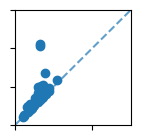

In [39]:
node = (0,0)
dgm = G.nodes[node]['diagram']
max_val = 0.3

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

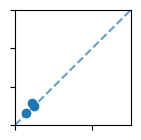

In [40]:
node = (7,0)
dgm = G.nodes[node]['diagram']
max_val = 0.3

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

For this example, we also show persistence images, which can be attached to each node. 

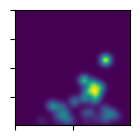

In [42]:
node = (0,0)
dgm = G.nodes[node]['diagram']
pixel_size = 0.001
birth_range = (0,0.1)
pers_range = (0,0.1)
kernel_params = {'sigma': [[0.00001, 0.0], [0.0, 0.00001]]}

pimgr = PersistenceImager(pixel_size=pixel_size, birth_range=birth_range,
                              pers_range = pers_range, kernel_params = kernel_params)

img = pimgr.transform(dgm)

flipped_img0 = img.T
flipped_img = flipped_img0[::-1]

fig, ax = plt.subplots(figsize=(1.5, 1.5))

# Plot the image
ax.imshow(flipped_img)

# Remove axis ticks and labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()

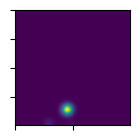

In [43]:
node = (7,0)
dgm = G.nodes[node]['diagram']
pixel_size = 0.001
birth_range = (0,0.1)
pers_range = (0,0.1)
kernel_params = {'sigma': [[0.00001, 0.0], [0.0, 0.00001]]}

pimgr = PersistenceImager(pixel_size=pixel_size, birth_range=birth_range,
                              pers_range = pers_range, kernel_params = kernel_params)

img = pimgr.transform(dgm)

flipped_img0 = img.T
flipped_img = flipped_img0[::-1]

fig, ax = plt.subplots(figsize=(1.5, 1.5))

# Plot the image
ax.imshow(flipped_img)

# Remove axis ticks and labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Show the plot
plt.show()

## Synthetic Example, Using Barcode Transforms

Finally, we come back to our synthetic example, but use the "barcode transform" method to attach persistence diagrams to each node --- see the paper for details.

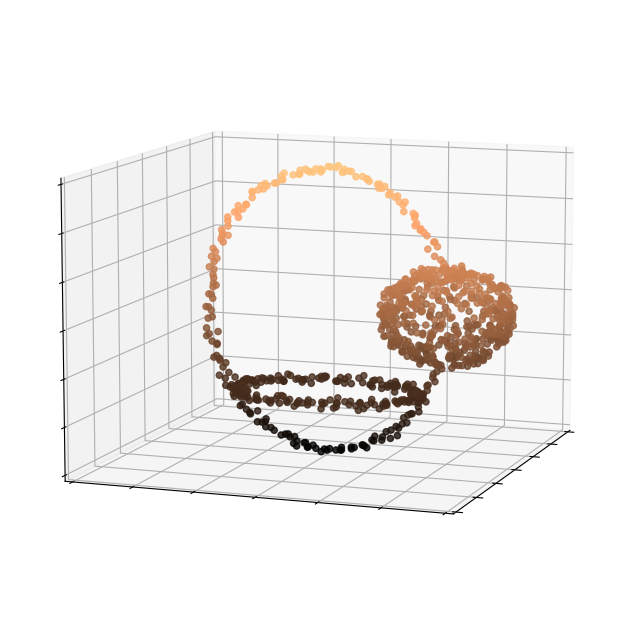

In [44]:
R = 0.75
N = 500

sphere = []

for n in range(N):
    v = R*(np.random.rand(3) - np.random.rand(3))
    sphere.append(v/np.linalg.norm(v))
    
sphere = np.array(sphere)
sphere_function = sphere[:,2]

ts = np.linspace(np.pi/8,2*np.pi-np.pi/8,200)
circle = np.array([np.zeros(len(ts)),2*np.cos(ts),3*np.sin(ts)]).T - np.array([0,2,0])

ts2 = np.linspace(0,2*np.pi,200)
circle2 = np.array([np.cos(ts2),1.5*np.sin(ts2),np.zeros(len(ts2))]).T + np.array([0,-2,-1.75])

data = np.vstack([sphere,circle,circle2]) + np.array([0,2,0])
data += np.random.normal(0,.05,data.shape)
function = data[:,2]

plot_3d_point_cloud(data, function = function)

In [45]:
DRG = DecoratedReebGraph(data = data, function = function)
DRG.fit_Vietoris_Rips(min_rad_factor=3)
DRG.fit_Reeb(n_bins=12)
DRG.fit_diagrams()

In [46]:
DRG.fit_diagrams_global()

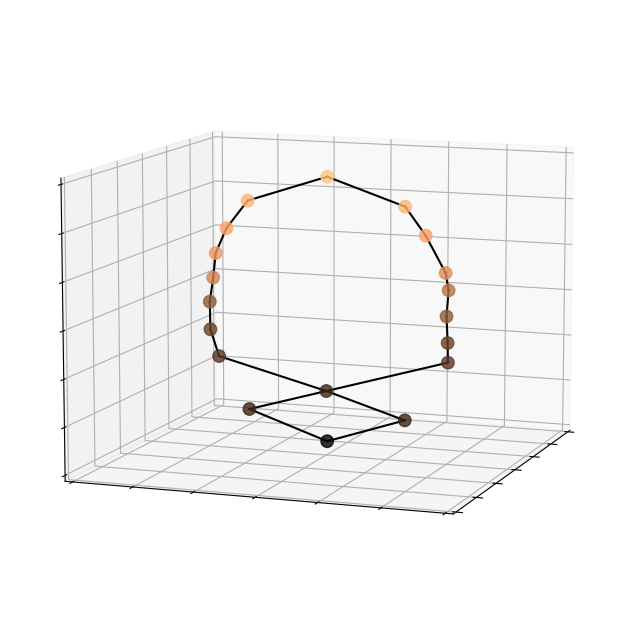

In [47]:
plot_Reeb_3d(DRG.ReebGraph, node_color = 'births_global')

In [48]:
G = DRG.ReebGraph

Plotting persistence diagrams associated to nodes.

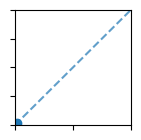

In [49]:
node = (0,0)
dgm = G.nodes[node]['global_diagram']
max_val = 10

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()

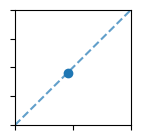

In [50]:
node = (10,0)
dgm = G.nodes[node]['global_diagram']
max_val = 10

fig = plt.figure(figsize = (1.5,1.5))
ax = fig.add_subplot()

ax.scatter(dgm[:,0],dgm[:,1],label = 'H1')
ax.set_xlim(0,max_val)
ax.set_ylim(0,max_val)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.plot([0,max_val],[0,max_val],linestyle='dashed',alpha = 0.7)

plt.show()